In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")

# median = np.median(data.bz.values)
# data.bz.values -= median


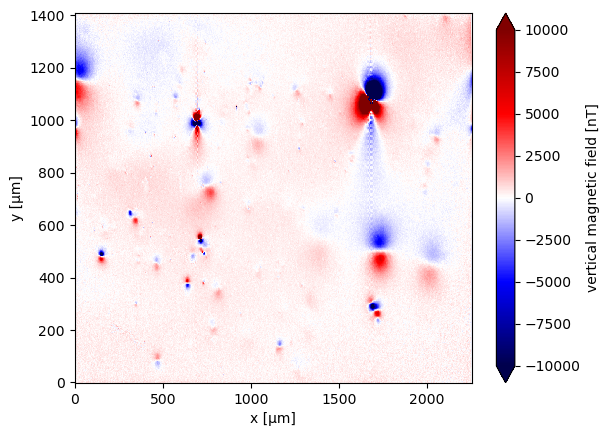

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional separation

In [4]:
data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=3).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset>
Dimensions:             (y: 600, x: 960)
Coordinates:
  * x                   (x) float64 0.0 2.35 4.7 ... 2.251e+03 2.254e+03
  * y                   (y) float64 0.0 2.35 4.7 ... 1.405e+03 1.408e+03
    z                   (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 511.2 251.3 195.7 ... -562.2 -508.7
    regional_predicted  (y, x) float64 -158.8 -156.5 -154.1 ... 508.7 510.8
Attributes:
    file_name:  ../data/Bz_uc0.mat

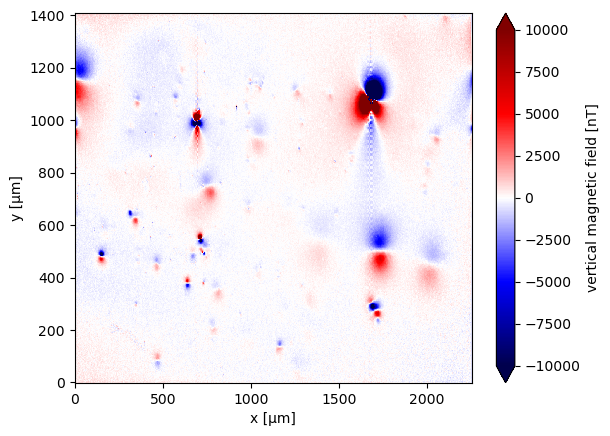

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

In [6]:
# table = vd.grid_to_table(data)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [7]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43

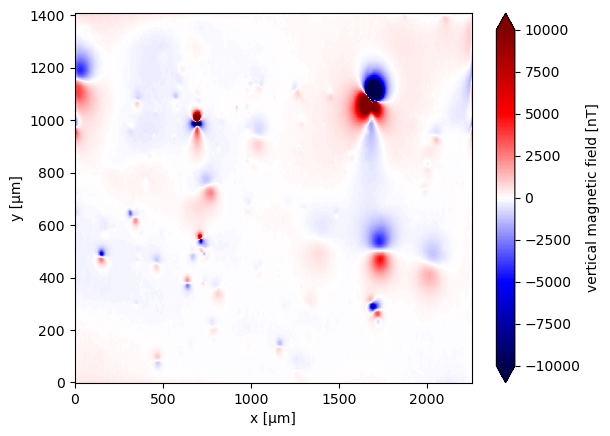

In [8]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [9]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43
    tga      (y, x) float64 41.31 39.91 30.8 31.58 ... 47.0 48.39 53.51 45.85
    x_deriv  (y, x) float64 39.52 32.11 21.76 16.75 ... 10.44 14.16 25.29 33.58
    y_deriv  (y, x) float64 -7.62 -9.232 -12.67 -16.62 ... -20.44 -16.89 -9.813
    z_deriv  (y, x) float64 -9.317 -21.84 -17.73 -20.98 ... 41.51 44.03 29.64

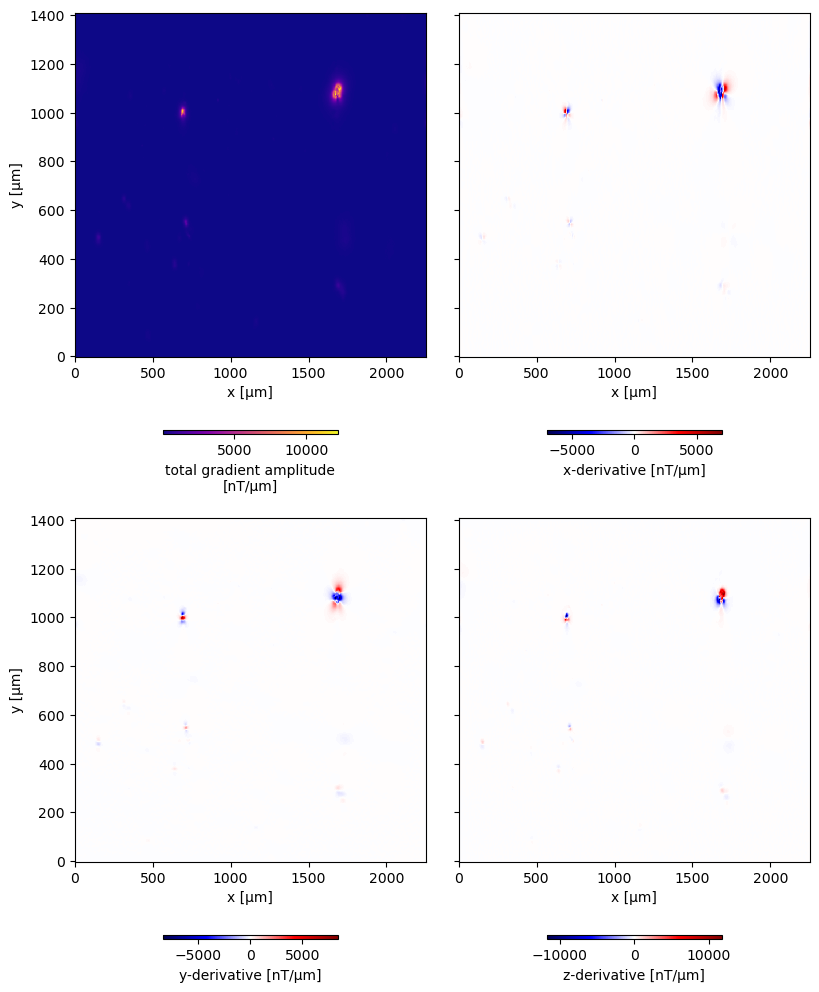

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [11]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)

data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

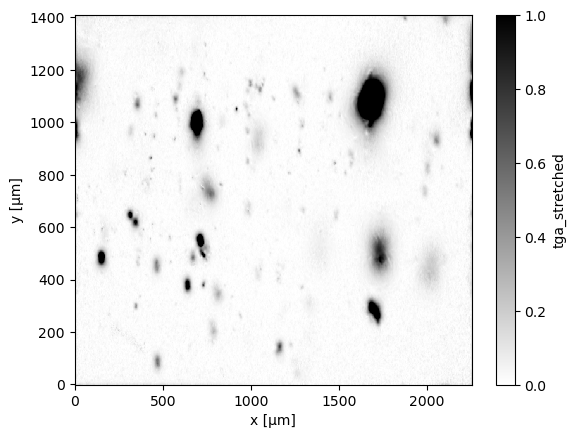

In [12]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [13]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)

end_detection_time = time.perf_counter()

In [14]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

103 potential sources detected within 1.597 seconds


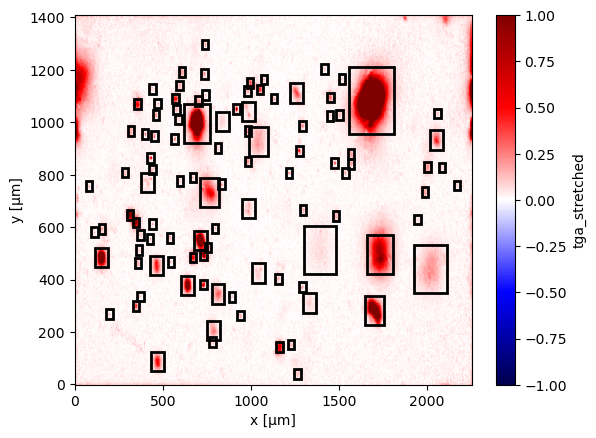

In [15]:
ax = plt.subplot(111)
scale = 1
data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [16]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    # anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    # base_level = 0
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )

    # Filter out solutions that don't meet quality criteria
    bad_euler = False#position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.5
    bad_euler = position[2] > 0
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

R²: 0.8878527951939019 and SNR: 9.517944479275986
R²: 0.9178851692032055 and SNR: 10.964809384702798
R²: 0.9948586689226697 and SNR: 23.165690995569147
R²: 0.7452779841090782 and SNR: 5.964801807504536
R²: 0.9729155534203094 and SNR: 15.67814385125379
R²: 0.9972381671760915 and SNR: 25.590652852864743
R²: 0.9813627301403227 and SNR: 17.472837828065714
R²: 0.9856082231719485 and SNR: 18.430009329184415
R²: 0.9992125990110751 and SNR: 31.41820738918149
R²: 0.7365573143491924 and SNR: 6.165869250349393
R²: 0.996239833881378 and SNR: 24.250699341089856
R²: 0.9604071776968944 and SNR: 14.087113682727313
R²: 0.9980080257589902 and SNR: 27.008186348321992
R²: 0.9961228684766804 and SNR: 24.2203603910197
R²: 0.94853832463246 and SNR: 13.055184725902782
R²: 0.9934869972882747 and SNR: 22.05326094866588
R²: 0.945068947610644 and SNR: 12.606043217455
R²: 0.9788424031522328 and SNR: 16.806435729017167
R²: 0.968856073448912 and SNR: 15.258707623563277
R²: 0.9658474884092434 and SNR: 14.805775593180

In [17]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

77 euler positions and dipole moments estimated within 2.2613 seconds


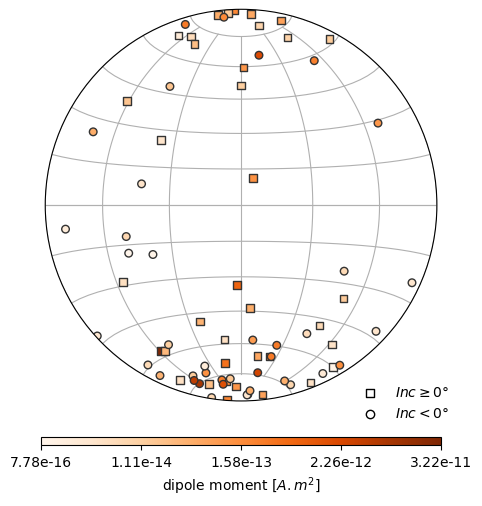

In [18]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Interactive Euler deconvolution

In [19]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])
# predicted_data = mg.dipole_bz(predicted_coordinates, positions, estimated_dipole_moments)

In [20]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

################################# identify and remove all models with r2 >= 0.99 at once
euler_r2 = np.array(calculated_r2) > 1.01

for window in rich.progress.track(np.array(windows_filtered)[euler_r2], total = len(np.array(windows_filtered)[euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    
    data_minus_background = anomaly.bz.values - base_level 
#     data_minus_background = data.sel(x=slice(*window[:2]), y=slice(*window[2:])).values
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)

      ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])  

# remove all signals 
position = np.array([xc_concat, yc_concat, zc_concat])
discard = mg.dipole_bz(coordinates, position, estimated_dipole_moments_itr_euler)
data_copy.bz.values -= discard



#################################
for window in rich.progress.track(np.array(windows_filtered)[~euler_r2], total = len(np.array(windows_filtered)[~euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     # using the real data to perform the dipole moment estimation
    # data_minus_background = data_copy['bz'].sel(x=slice(*window[:2]), y=slice(*window[2:])).values 
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

Output()

R²: 0.8878527951939019 and SNR: 9.517944479275986 | -20.17769179909661

R²: 0.9178845780585253 and SNR: 10.964788698405624 | -5.931108133835349

R²: 0.9948590294327446 and SNR: 23.165695243889214 | -9.93711894558329

R²: 0.7453371151629831 and SNR: 5.9655599880613375 | -14.622554425041521

R²: 0.9729133603813921 and SNR: 15.677844068582491 | -4.43777242807157

R²: 0.9972635297814819 and SNR: 25.629302224400234 | -8.655718340926283

R²: 0.9813485904285834 and SNR: 17.470865694842175 | -9.967186169282822

R²: 0.9977080722886525 and SNR: 26.524802429089426 | -14.026404079366937

R²: 0.9991980839257365 and SNR: 31.370252422343675 | -59.50266514111542

R²: 0.7663806697408428 and SNR: 6.626296280380862 | -2.2064451557312843

R²: 0.9962327025942226 and SNR: 24.242548925670956 | -12.510519885874846

R²: 0.963492019429885 and SNR: 14.438691920752586 | -2.329489410360908

R²: 0.9980543788994392 and SNR: 27.110432104282477 | -13.239536907242048

R²: 0.9961250590983913 and SNR: 24.22153439045269 | -14.268606351320997

R²: 0.9494826223971061 and SNR: 13.100089336108109 | -9.59729019942289

R²: 0.9895836228412901 and SNR: 19.966937591429115 | -13.898063825707297

R²: 0.9455826745496506 and SNR: 12.647401012534534 | -40.59586865593093

R²: 0.9789080779139536 and SNR: 16.81492531322363 | -15.697826404546223

R²: 0.9689298424214448 and SNR: 15.259056993910612 | -1.4121949463985795

R²: 0.9658711895880487 and SNR: 14.809746947953496 | -7.841202007676312

R²: 0.9841848411133903 and SNR: 18.35070322507782 | -20.2076271224373

R²: 0.9408582117166856 and SNR: 12.300510597495782 | -1.360621947741178

R²: 0.7488397980269632 and SNR: 6.0554669951450215 | -0.6002730690658804

R²: 0.9631260373661448 and SNR: 14.420818279117782 | -16.01842693643261

R²: 0.9758730343746923 and SNR: 16.368346756951265 | -24.100610730933802

R²: 0.981436086832153 and SNR: 17.383768717656427 | -12.856181469547012

R²: 0.7956202161701713 and SNR: 6.91301393891681 | -16.199267814310087

R²: 0.9572806234175385 and SNR: 13.74299732998434 | -4.769427639296407

R²: 0.9950085027469296 and SNR: 23.502841859140517 | -70.75663431239573

R²: 0.9389299988286952 and SNR: 12.185351819643266 | -6.273640762479138

R²: 0.9135462635286351 and SNR: 10.747107986637259 | -9.122858965239502

R²: 0.7702215703231152 and SNR: 6.91319517271897 | -0.7807413407397619

R²: 0.9181359554470718 and SNR: 10.898142622756799 | -11.660737120688857

R²: 0.9686389835157644 and SNR: 15.885775009516705 | -4.860011095244502

R²: 0.9596840717153399 and SNR: 13.947215110825994 | -19.614463310029116

R²: 0.9790918470971093 and SNR: 16.799925393509753 | -45.43749682226593

R²: 0.9706768464938199 and SNR: 15.469856533066789 | -1.583565727521683

R²: 0.9942590981078095 and SNR: 22.476582164150045 | -12.272946509651694

R²: 0.7029669666832048 and SNR: 5.297404500084701 | -8.86010221255593

R²: 0.524261623653808 and SNR: 3.290148654194639 | -2.6919495191627965

R²: 0.7523701834804799 and SNR: 6.219366376507683 | -4.900354422645824

R²: 0.5103801382922676 and SNR: 3.1506621067599063 | -0.19090432613717834

R²: 0.9535232018574691 and SNR: 13.465861448993543 | -14.044300854341591

R²: 0.7610156978285673 and SNR: 6.4557976223617475 | -3.3629083432347047

R²: 0.7335417982205816 and SNR: 5.7677353290162126 | -12.682421860607832

R²: 0.6107173552653848 and SNR: 4.193877346683504 | -1.1796927833008652

R²: 0.7993243331973868 and SNR: 7.115891442941198 | -8.125947096969574

R²: 0.9390419878314538 and SNR: 12.15014289318005 | -4.320728286927963

R²: 0.9626937400340594 and SNR: 14.480665835658264 | -8.071883466871096

R²: 0.8875985508660083 and SNR: 9.529740435441685 | -5.063616964519114

R²: 0.6350084877268606 and SNR: 4.379824781871008 | -0.6384762475311658

R²: 0.9620970435232948 and SNR: 14.377844250049755 | -16.098275554243145

R²: 0.7861874589640026 and SNR: 6.704452816348346 | -3.9199456954730687

R²: 0.7184120552315225 and SNR: 5.59135073488366 | -8.563323370216608

R²: 0.8631042109956423 and SNR: 8.639327821004636 | -14.022717714855027

R²: 0.8980264370408327 and SNR: 11.662109469148945 | -4.720635162915284

R²: 0.9645345458016762 and SNR: 14.547167647960851 | -22.63552288169672

R²: 0.8143472606102822 and SNR: 7.313230327239221 | -4.981905344565348

R²: 0.36267360014082783 and SNR: 2.0778790424714595 | 0.2857902611879821

R²: 0.6878278471729704 and SNR: 5.1028706137941136 | 0.24131881293445148

R²: 0.4875879586088602 and SNR: 2.905593836365222 | -7.075885109329884

R²: 0.9353986437184427 and SNR: 12.03899927082704 | -18.051644227249813

R²: 0.9785886716535876 and SNR: 16.952450805345237 | -14.025500410220703

R²: 0.9425654469847201 and SNR: 12.458314462985157 | -3.025731133826597

R²: 0.9203559798783688 and SNR: 11.522334239202557 | -33.655822872820224

R²: 0.6388736791347464 and SNR: 5.129519881506781 | -5.2961032156354335

R²: 0.36976111872737494 and SNR: 2.009985634353092 | -2.6754543610236494

R²: 0.41284168160429646 and SNR: 2.6945676261823763 | -5.361286552966644

R²: 0.6503394247700933 and SNR: 4.569151480159079 | -2.8522900693256514

R²: 0.8452306889078796 and SNR: 8.48966455496948 | -7.146831830521412

R²: 0.5223863766757662 and SNR: 3.421062892368984 | -3.4867625782605054

R²: 0.6172182632098946 and SNR: 4.206099879782339 | -6.217118012987127

R²: 0.6780332496366186 and SNR: 5.091062567701503 | -1.368477055268575

R²: 0.7005286036283171 and SNR: 5.488264995974377 | -10.43218943275415

R²: 0.7728859943707319 and SNR: 6.487229605476924 | -10.988041867252987

R²: 0.936277631083807 and SNR: 12.350600855259577 | -77.8958594106554

R²: 0.6847660941979559 and SNR: 5.043009159407502 | -12.30606998789471

In [21]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 16.7256 seconds


In [22]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,1558.05,956.45,10.0,862.733018,-4.135768
1,1560.40,956.45,10.0,877.250755,-1.879860
2,1562.75,956.45,10.0,889.260627,-0.087959
3,1565.10,956.45,10.0,900.298867,-3.467666
4,1567.45,956.45,10.0,905.623621,-0.826973


In [23]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
# print(positions_itr)

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

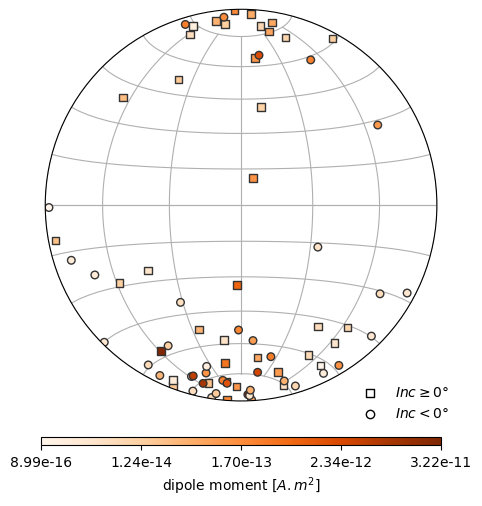

In [24]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $b_z$ vector

In [25]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [26]:
start_interf_bz_time = time.perf_counter()

estimated_dipole_moments_interf_bz = all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_bz_time = time.perf_counter()

In [27]:
interf_bz_time = end_interf_bz_time-start_interf_bz_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_bz_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 17.38 seconds


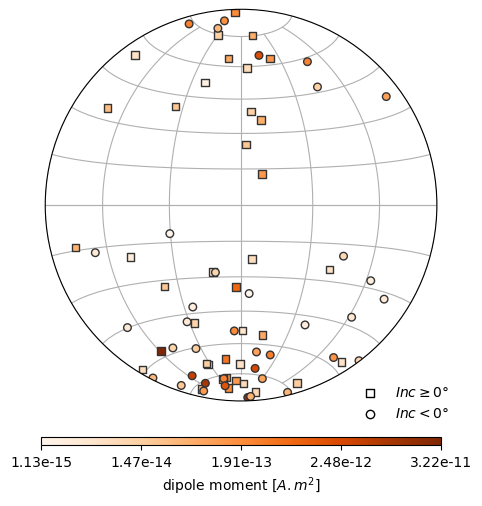

In [28]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_bz)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $\frac{\partial b_z}{\partial z}$ vector

In [29]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [30]:
start_interf_z_deriv_time = time.perf_counter()

estimated_dipole_moments_interf_z_deriv = z_deriv_all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_z_deriv_time = time.perf_counter()

In [31]:
interf_z_deriv_time = end_interf_z_deriv_time-start_interf_z_deriv_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_z_deriv_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 17.37 seconds


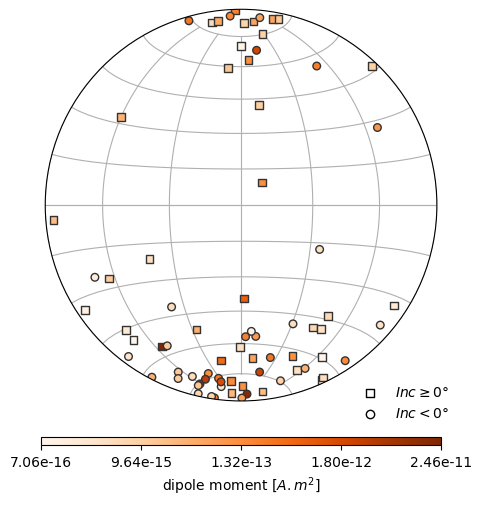

In [32]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Final Comparison

In [33]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

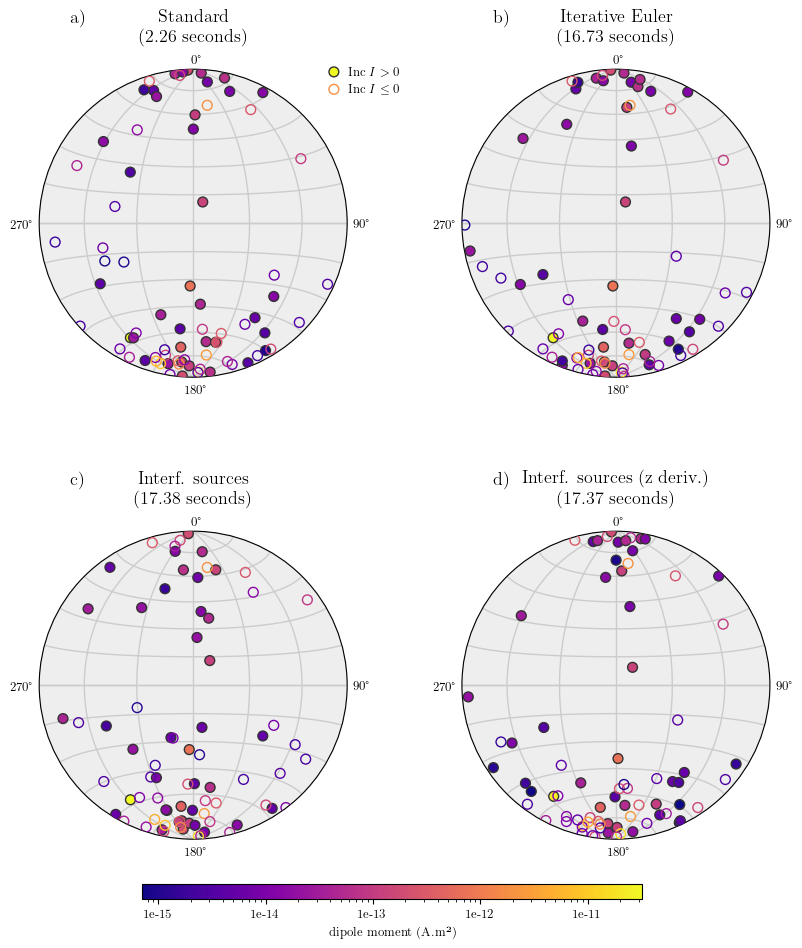

In [34]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(10, 10))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]
    estimated3 = mg.vector_to_angles(estimated_dipole_moments_interf_bz)[2]
    estimated4 = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)[2]
    
    vmin = np.min([np.min(estimated1),np.min(estimated2),np.min(estimated3),np.min(estimated4)])
    vmax = np.max([np.max(estimated1),np.max(estimated2),np.max(estimated3),np.max(estimated4)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
        
    ## STANDARD METHOD
    ax = fig.add_subplot(2, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    
    
    ## ITERATIVE METHOD
    ax = fig.add_subplot(2, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    ## ITERATIVE METHOD W/ Bz DATA
    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_bz, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    
    ## ITERATIVE METHOD W/ Bz deriv DATA
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_z_deriv, marker="o", zorder=1000, label="Inc", **kwargs)

    
           
    
    
    
    
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iterative Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.1, 1.15, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()

# R-squared score filter

In [35]:
def calculated_r2_interf_sources_bz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.bz.values - pred_up_slice.bz.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.bz.values - np.mean(data_up_slice.bz.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)



def calculated_r2_interf_sources_bzz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
#     # remove median
#     median = np.median(data.bz.values)
#     data.bz.values -= median
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    data_up = data_up.assign(mg.data_gradients(data_up.bz))
    pred_up = data_up.assign(mg.data_gradients(pred_up.bz))
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.z_deriv.values - pred_up_slice.z_deriv.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.z_deriv.values - np.mean(data_up_slice.z_deriv.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)

In [36]:
import warnings
warnings.filterwarnings('ignore')

calculated_r2_interf_bz = calculated_r2_interf_sources_bz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_bz, 
                                                    np.array(windows_filtered), height_difference)

calculated_r2_interf_z_deriv = calculated_r2_interf_sources_bzz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_z_deriv, 
                                                    np.array(windows_filtered), height_difference)


In [37]:
print(np.array(calculated_r2)[np.array(calculated_r2)>=0.85])
print()
print(calculated_r2_itr_euler[calculated_r2_itr_euler>=0.85])
print()
print(calculated_r2_interf_bz[calculated_r2_interf_bz>=0.85])
print()
print(calculated_r2_interf_z_deriv[calculated_r2_interf_z_deriv>=0.85])

[0.8878528  0.91788517 0.99485867 0.97291555 0.99723817 0.98136273
 0.98560822 0.9992126  0.99623983 0.96040718 0.99800803 0.99612287
 0.94853832 0.993487   0.94506895 0.9788424  0.96885607 0.96584749
 0.98414322 0.93951523 0.96301255 0.97587688 0.95751736 0.95442627
 0.99399569 0.94211686 0.91260801 0.90494371 0.97044579 0.95915294
 0.98630396 0.97211076 0.9915754  0.95287709 0.88543787 0.95255813
 0.86418194 0.88657742 0.86307257 0.93169246 0.9653689  0.92403831
 0.98089644 0.9227599  0.92393283 0.94340219]

[0.8878528  0.91788458 0.99485903 0.97291336 0.99726353 0.98134859
 0.99770807 0.99919808 0.9962327  0.96349202 0.99805438 0.99612506
 0.94948262 0.98958362 0.94558267 0.97890808 0.96892984 0.96587119
 0.98418484 0.94085821 0.96312604 0.97587303 0.98143609 0.95728062
 0.9950085  0.93893    0.91354626 0.91813596 0.96863898 0.95968407
 0.97909185 0.97067685 0.9942591  0.9535232  0.93904199 0.96269374
 0.88759855 0.96209704 0.86310421 0.89802644 0.96453455 0.93539864
 0.97858867 0.9

# Paper's figures 

In [38]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

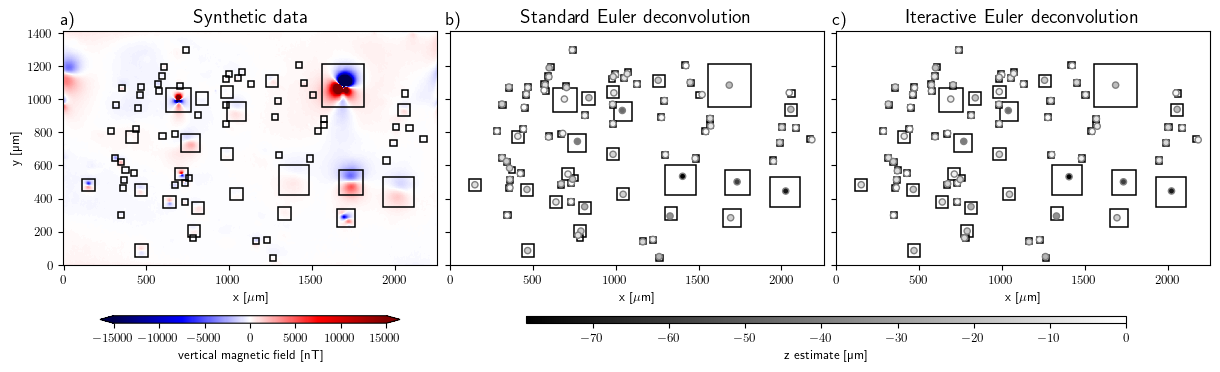

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2], positions_itr[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iteractive Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()
